**A recommender system can use collaborative filtering or content-based filtering. Collaborative filtering approaches build a model from a user's past behaviour as well as similar decisions made by other users. Content-based filtering approaches utilize a series of discrete characteristics of an item in order to recommend additional items with similar properties.
Collaborative filtering is used in this example.**

** The data files are downloaded from MovieLens at https://grouplens.org/datasets/movielens/. 'ratings.csv' contains userId/movieId/rating/timestamp. 'movies.csv' contains movieId/title/genre.**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

** Import and QC data files **

In [2]:
import ibmos2spark

# @hidden_cell
credentials = {
    'auth_url': 'https://identity.open.softlayer.com',
    'project_id': '5255011bbec640b5b65887c30a697775',
    'region': 'dallas',
    'user_id': 'd5a715617ba24fb28fa27e6c37016cd5',
    'username': 'member_961fb9fb8cbcdb9c05c7f761d07710754f04e371',
    'password': 'I*7eN0xng.ZgZvsK'
}

configuration_name = 'os_2324dd88d6d2434d8e40abae94b1b978_configs'
bmos = ibmos2spark.bluemix(sc, credentials, configuration_name)

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
df_ratings = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .option('inferSchema','true')\
  .load(bmos.url('DefaultProjecthongsang1976gmailcom', 'ratings.csv'))
df_ratings.take(5)

[Row(userId=1, movieId=31, rating=2.5, timestamp=1260759144),
 Row(userId=1, movieId=1029, rating=3.0, timestamp=1260759179),
 Row(userId=1, movieId=1061, rating=3.0, timestamp=1260759182),
 Row(userId=1, movieId=1129, rating=2.0, timestamp=1260759185),
 Row(userId=1, movieId=1172, rating=4.0, timestamp=1260759205)]

In [3]:
df_ratings.describe().show()

+-------+------------------+------------------+------------------+--------------------+
|summary|            userId|           movieId|            rating|           timestamp|
+-------+------------------+------------------+------------------+--------------------+
|  count|            100004|            100004|            100004|              100004|
|   mean| 347.0113095476181|12548.664363425463| 3.543608255669773|1.1296390869392424E9|
| stddev|195.16383797819535|26369.198968815268|1.0580641091070326|1.9168582602710962E8|
|    min|                 1|                 1|               0.5|           789652009|
|    max|               671|            163949|               5.0|          1476640644|
+-------+------------------+------------------+------------------+--------------------+



In [4]:
df_movies = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .option('inferSchema','true')\
  .load(bmos.url('DefaultProjecthongsang1976gmailcom', 'movies.csv'))
df_movies.take(5)

[Row(movieId=1, title='Toy Story (1995)', genres='Adventure|Animation|Children|Comedy|Fantasy'),
 Row(movieId=2, title='Jumanji (1995)', genres='Adventure|Children|Fantasy'),
 Row(movieId=3, title='Grumpier Old Men (1995)', genres='Comedy|Romance'),
 Row(movieId=4, title='Waiting to Exhale (1995)', genres='Comedy|Drama|Romance'),
 Row(movieId=5, title='Father of the Bride Part II (1995)', genres='Comedy')]

In [5]:
df_movies.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



In [6]:
df_movies.describe().show()

+-------+------------------+--------------------+------------------+
|summary|           movieId|               title|            genres|
+-------+------------------+--------------------+------------------+
|  count|              9125|                9125|              9125|
|   mean|31123.291835616437|                null|              null|
| stddev| 40782.63360397416|                null|              null|
|    min|                 1|"""Great Performa...|(no genres listed)|
|    max|            164979| İtirazım Var (2014)|           Western|
+-------+------------------+--------------------+------------------+



In [7]:
df_movies.filter("title == 'Star Wars: Episode IV - A New Hope (1977)'").show(truncate=False)

+-------+-----------------------------------------+-----------------------+
|movieId|title                                    |genres                 |
+-------+-----------------------------------------+-----------------------+
|260    |Star Wars: Episode IV - A New Hope (1977)|Action|Adventure|Sci-Fi|
+-------+-----------------------------------------+-----------------------+



In [40]:
df_ratings.filter("movieId == 260 and rating == 5.0").show()

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     4|    260|   5.0| 949779042|
|     7|    260|   5.0| 851869062|
|    15|    260|   5.0| 997938437|
|    36|    260|   5.0| 847057564|
|    55|    260|   5.0| 855927131|
|    63|    260|   5.0|1078570677|
|    66|    260|   5.0| 974600461|
|    74|    260|   5.0| 942705457|
|    78|    260|   5.0|1274050755|
|    86|    260|   5.0| 848161982|
|    89|    260|   5.0|1257620279|
|    91|    260|   5.0|1448798105|
|    95|    260|   5.0|1018816569|
|   102|    260|   5.0| 956598697|
|   116|    260|   5.0|1163454699|
|   118|    260|   5.0| 951008797|
|   119|    260|   5.0| 913052591|
|   125|    260|   5.0|1244537436|
|   137|    260|   5.0| 946412230|
|   146|    260|   5.0|1256071143|
+------+-------+------+----------+
only showing top 20 rows



** Match movie titles with movieId numbers in the ratings **

In [9]:
df = pd.merge(df_ratings.toPandas(),df_movies.toPandas(),on='movieId')
df = spark.createDataFrame(df)
df = df.select('userId','movieId',df.rating.cast('float'),'title','genres')
df.show(truncate=False)

+------+-------+------+----------------------+------+
|userId|movieId|rating|title                 |genres|
+------+-------+------+----------------------+------+
|1     |31     |2.5   |Dangerous Minds (1995)|Drama |
|7     |31     |3.0   |Dangerous Minds (1995)|Drama |
|31    |31     |4.0   |Dangerous Minds (1995)|Drama |
|32    |31     |4.0   |Dangerous Minds (1995)|Drama |
|36    |31     |3.0   |Dangerous Minds (1995)|Drama |
|39    |31     |3.0   |Dangerous Minds (1995)|Drama |
|73    |31     |3.5   |Dangerous Minds (1995)|Drama |
|88    |31     |3.0   |Dangerous Minds (1995)|Drama |
|96    |31     |2.5   |Dangerous Minds (1995)|Drama |
|110   |31     |4.0   |Dangerous Minds (1995)|Drama |
|111   |31     |3.5   |Dangerous Minds (1995)|Drama |
|150   |31     |2.5   |Dangerous Minds (1995)|Drama |
|161   |31     |3.0   |Dangerous Minds (1995)|Drama |
|165   |31     |3.5   |Dangerous Minds (1995)|Drama |
|186   |31     |3.0   |Dangerous Minds (1995)|Drama |
|242   |31     |4.0   |Dange

In [10]:
df.printSchema()

root
 |-- userId: long (nullable = true)
 |-- movieId: long (nullable = true)
 |-- rating: float (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



** Visualize rating distribubtion **

(0, 671)

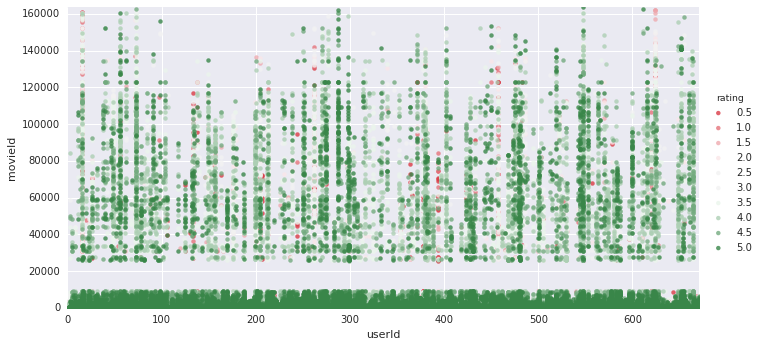

In [11]:
lm = sns.lmplot(x='userId', y='movieId', hue='rating', data=df.toPandas(), fit_reg=False, 
                size=5, aspect=2, palette=sns.diverging_palette(10, 133, sep=80, n=10))
axes = lm.axes
axes[0,0].set_ylim(0,163949) # max movieId is 163949
axes[0,0].set_xlim(0,671) # max userId is 671

In [12]:
df.groupBy('genres').mean('rating').sort('avg(rating)',ascending=False).show(truncate=False)

+------------------------------------------+-----------------+
|genres                                    |avg(rating)      |
+------------------------------------------+-----------------+
|Action|Comedy|Horror|Romance|Sci-Fi       |5.0              |
|Action|Adventure|Animation|Comedy|Fantasy |5.0              |
|Comedy|Drama|Fantasy|Musical              |5.0              |
|Comedy|Drama|Romance|Western              |5.0              |
|Drama|Fantasy|Musical|Mystery|Sci-Fi      |5.0              |
|Adventure|Animation|Drama|Mystery|Sci-Fi  |5.0              |
|Animation|Comedy|Drama|Fantasy|Sci-Fi     |5.0              |
|Comedy|Drama|Fantasy|Musical|Romance      |5.0              |
|Action|Fantasy|Horror|Sci-Fi|Thriller     |5.0              |
|Action|Comedy|Drama|Romance               |5.0              |
|Comedy|Fantasy|Horror|Musical|Thriller    |5.0              |
|Adventure|Documentary|Drama               |5.0              |
|Adventure|Children|Fantasy|Musical|Romance|5.0        

** Find the most rated movies **

In [13]:
df.groupBy('title').count().sort('count', ascending=False).show(truncate=False)

+------------------------------------------------------------------------------+-----+
|title                                                                         |count|
+------------------------------------------------------------------------------+-----+
|Forrest Gump (1994)                                                           |341  |
|Pulp Fiction (1994)                                                           |324  |
|Shawshank Redemption, The (1994)                                              |311  |
|Silence of the Lambs, The (1991)                                              |304  |
|Star Wars: Episode IV - A New Hope (1977)                                     |291  |
|Jurassic Park (1993)                                                          |274  |
|Matrix, The (1999)                                                            |259  |
|Toy Story (1995)                                                              |247  |
|Schindler's List (1993)                   

** Show the highest rated movies with more than 100 ratings **

In [14]:
df_count = df.groupBy('title').count()
df_mean = df.groupBy('title').mean('rating')
df_sort = pd.merge(df_count.toPandas(),df_mean.toPandas(),on='title')
#df_sort.sort_values(by='avg(rating)').sort_values(by='count',ascending=False).head()
df_sort.sort_values(by='avg(rating)',ascending=False).loc[df_sort['count']>=100].head(20)

,title,count,avg(rating)
6996,"Godfather, The (1972)",200,4.487500
2402,"Shawshank Redemption, The (1994)",311,4.487138
4314,"Godfather: Part II, The (1974)",135,4.385185
2180,"Usual Suspects, The (1995)",201,4.370647
4520,Schindler's List (1993),244,4.303279
4891,One Flew Over the Cuckoo's Nest (1975),144,4.256944
5140,Fargo (1996),224,4.256696
7332,Pulp Fiction (1994),324,4.256173
6466,American Beauty (1999),220,4.236364
1008,"Dark Knight, The (2008)",121,4.235537


** Split data into training and test set **

In [15]:
(training, test) = df.randomSplit([0.8, 0.2])

In [16]:
print('Size of training set: ' + str(training.count()))
print('Size of test set: ' + str(test.count()))

Size of training set: 79944
Size of test set: 20060


In [17]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

In [18]:
als = ALS(maxIter=5, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating")
model = als.fit(training)

In [19]:
predictions_test = model.transform(test)
predictions_test.show(truncate=False)

+------+-------+------+---------------------------+-----------------------------+----------+
|userId|movieId|rating|title                      |genres                       |prediction|
+------+-------+------+---------------------------+-----------------------------+----------+
|452   |463    |2.0   |Guilty as Sin (1993)       |Crime|Drama|Thriller         |2.4134862 |
|30    |463    |4.0   |Guilty as Sin (1993)       |Crime|Drama|Thriller         |3.6990101 |
|311   |463    |3.0   |Guilty as Sin (1993)       |Crime|Drama|Thriller         |2.697079  |
|126   |471    |5.0   |Hudsucker Proxy, The (1994)|Comedy                       |4.47006   |
|491   |471    |3.0   |Hudsucker Proxy, The (1994)|Comedy                       |4.668893  |
|299   |471    |4.5   |Hudsucker Proxy, The (1994)|Comedy                       |4.891708  |
|15    |471    |3.0   |Hudsucker Proxy, The (1994)|Comedy                       |2.6313536 |
|358   |471    |5.0   |Hudsucker Proxy, The (1994)|Comedy             

In [20]:
predictions_all = model.transform(df)
predictions_all.show(truncate=False)

+------+-------+------+--------------------------------+--------------------+----------+
|userId|movieId|rating|title                           |genres              |prediction|
+------+-------+------+--------------------------------+--------------------+----------+
|575   |148    |4.0   |Awfully Big Adventure, An (1995)|Drama               |4.2742333 |
|232   |463    |4.0   |Guilty as Sin (1993)            |Crime|Drama|Thriller|4.1305566 |
|452   |463    |2.0   |Guilty as Sin (1993)            |Crime|Drama|Thriller|2.4134862 |
|534   |463    |4.0   |Guilty as Sin (1993)            |Crime|Drama|Thriller|4.027559  |
|242   |463    |4.0   |Guilty as Sin (1993)            |Crime|Drama|Thriller|4.073439  |
|380   |463    |3.0   |Guilty as Sin (1993)            |Crime|Drama|Thriller|3.0524845 |
|30    |463    |4.0   |Guilty as Sin (1993)            |Crime|Drama|Thriller|3.6990101 |
|311   |463    |3.0   |Guilty as Sin (1993)            |Crime|Drama|Thriller|2.697079  |
|85    |471    |3.0  

In [21]:
predictions_all.printSchema()

root
 |-- userId: long (nullable = true)
 |-- movieId: long (nullable = true)
 |-- rating: float (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- prediction: float (nullable = true)



In [22]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",predictionCol="prediction")
rmse = evaluator.evaluate(predictions_test.dropna(subset=('rating','prediction')))
print("Root-mean-square error (test set) = " + str(rmse))
rmse = evaluator.evaluate(predictions_all.dropna(subset=('rating','prediction')))
print("Root-mean-square error (full set) = " + str(rmse))

Root-mean-square error (test set) = 1.1226515049605343
Root-mean-square error (full set) = 0.6820747303440744


In [23]:
single_movie = predictions_test.filter(predictions_test['movieId']==260).orderBy(predictions_test['rating'].desc())
single_movie.show(truncate=False)

+------+-------+------+-----------------------------------------+-----------------------+----------+
|userId|movieId|rating|title                                    |genres                 |prediction|
+------+-------+------+-----------------------------------------+-----------------------+----------+
|599   |260    |5.0   |Star Wars: Episode IV - A New Hope (1977)|Action|Adventure|Sci-Fi|4.2732906 |
|647   |260    |5.0   |Star Wars: Episode IV - A New Hope (1977)|Action|Adventure|Sci-Fi|4.4038277 |
|173   |260    |5.0   |Star Wars: Episode IV - A New Hope (1977)|Action|Adventure|Sci-Fi|4.219315  |
|486   |260    |5.0   |Star Wars: Episode IV - A New Hope (1977)|Action|Adventure|Sci-Fi|3.919739  |
|594   |260    |5.0   |Star Wars: Episode IV - A New Hope (1977)|Action|Adventure|Sci-Fi|4.3170347 |
|537   |260    |5.0   |Star Wars: Episode IV - A New Hope (1977)|Action|Adventure|Sci-Fi|4.5635543 |
|463   |260    |5.0   |Star Wars: Episode IV - A New Hope (1977)|Action|Adventure|Sci-Fi|4.

In [105]:
user_test = 50
single_user_training = training.filter(training['userId']==user_test).orderBy(training['rating'].desc())\
                      .select('userId','movieId','title','rating').show(truncate=False)
single_user = predictions_test.filter(predictions_test['userId']==user_test).orderBy(predictions_test['prediction'].desc())\
             .select('userId','movieId','title','prediction').dropna(how='any').show(truncate=False)

+------+-------+---------------------------------------------------------+------+
|userId|movieId|title                                                    |rating|
+------+-------+---------------------------------------------------------+------+
|50    |589    |Terminator 2: Judgment Day (1991)                        |5.0   |
|50    |110    |Braveheart (1995)                                        |4.0   |
|50    |296    |Pulp Fiction (1994)                                      |4.0   |
|50    |356    |Forrest Gump (1994)                                      |4.0   |
|50    |161    |Crimson Tide (1995)                                      |4.0   |
|50    |367    |Mask, The (1994)                                         |4.0   |
|50    |440    |Dave (1993)                                              |4.0   |
|50    |480    |Jurassic Park (1993)                                     |4.0   |
|50    |292    |Outbreak (1995)                                          |4.0   |
|50    |780    |

In [94]:
df.filter("title == 'Star Wars: Episode V - The Empire Strikes Back (1980)'\
          and rating == 5.0").show(truncate=False)

+------+-------+------+-----------------------------------------------------+-----------------------+
|userId|movieId|rating|title                                                |genres                 |
+------+-------+------+-----------------------------------------------------+-----------------------+
|4     |1196   |5.0   |Star Wars: Episode V - The Empire Strikes Back (1980)|Action|Adventure|Sci-Fi|
|7     |1196   |5.0   |Star Wars: Episode V - The Empire Strikes Back (1980)|Action|Adventure|Sci-Fi|
|15    |1196   |5.0   |Star Wars: Episode V - The Empire Strikes Back (1980)|Action|Adventure|Sci-Fi|
|19    |1196   |5.0   |Star Wars: Episode V - The Empire Strikes Back (1980)|Action|Adventure|Sci-Fi|
|42    |1196   |5.0   |Star Wars: Episode V - The Empire Strikes Back (1980)|Action|Adventure|Sci-Fi|
|62    |1196   |5.0   |Star Wars: Episode V - The Empire Strikes Back (1980)|Action|Adventure|Sci-Fi|
|73    |1196   |5.0   |Star Wars: Episode V - The Empire Strikes Back (1980)|Actio